In [ ]:
from google.colab import drive
drive.mount('/gdrive')
#Change current working directory to gdrive
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
import pandas as pd
import numpy as np

approach_features = r'/gdrive/Shared drives/MSBA Capstone/ML_Model/approachshots_features_final.csv'
approach_features = pd.read_csv(approach_features)
approach_features.drop(columns = ["Unnamed: 0"], inplace = True)
approach_features.head()

,userId,clubId,clubType,Group,distance,Avg_Handicap,isGir,New_Strokesgained,clubTypeId,gender,imp_age
0,0009469048f711e88cec4ff65cdf22e1,1,Dr,Others,312.757996,4.941176,1.000000,0.645,1,M,29.0
1,0009469048f711e88cec4ff65cdf22e1,2,3w,Others,256.512497,4.941176,1.000000,0.505,2,M,29.0
2,0009469048f711e88cec4ff65cdf22e1,3,3h,Others,193.232498,4.941176,1.000000,0.125,35,M,29.0
3,0009469048f711e88cec4ff65cdf22e1,5,5i,Others,158.133499,4.941176,1.000000,-0.240,6,M,29.0
4,0009469048f711e88cec4ff65cdf22e1,6,6i,Others,112.571136,4.941176,0.666667,-0.410,7,M,29.0


In [ ]:
X = approach_features.drop(['New_Strokesgained','userId','clubId'], axis=1)
y = approach_features['New_Strokesgained']

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
Xtrain = Xtrain.copy()
Xtest = Xtest.copy()
ytrain = ytrain.copy()
ytest = ytest.copy()

In [ ]:
# Preprocessing Train Dataset
# Robust Scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
# removes the median and scales the data according to the inter-quartile range (defaults to Q3-Q1)
# xi_scale = (xi - Q2(x))/(Q3(x) - Q1(x)) where Q1, Q2, and Q3 are 25th, 50th and 75th quantiles
# robust to outliers, but the outliers themselves are still present in the transformed data.

numericvars = ['Avg_Handicap', 	'distance', 	'isGir', 'imp_age']
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
dfnumrs = pd.DataFrame(rs.fit_transform(Xtrain[numericvars]), columns=['rs_'+x for x in numericvars], index = Xtrain.index)
dfnumrs = pd.concat([Xtrain, dfnumrs], axis=1)
dfnumrs = dfnumrs.drop(numericvars, axis=1)
dfnumrs.head()

,clubType,Group,clubTypeId,gender,rs_Avg_Handicap,rs_distance,rs_isGir,rs_imp_age
25908,7i,Game Improvement,8,M,-0.642319,0.546370,0.357143,-0.742809
37619,9i,Others,10,M,0.469194,0.217428,0.357143,-0.680309
48430,8i,Game Improvement,9,M,-0.426540,0.129039,0.357143,0.944691
40113,4h,Others,36,M,-0.294313,1.035194,0.107143,0.007191
30924,9i,Others,10,M,-1.313744,0.132523,-0.892857,0.257191


In [ ]:
categoricalvars = ['clubTypeId', 'clubType', 'Group', 'gender']
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto', drop='first', handle_unknown='error', sparse=False, dtype=int)
dfcat = pd.DataFrame(ohe.fit_transform(dfnumrs[categoricalvars]), columns=ohe.get_feature_names(),index = dfnumrs.index)
dfcat = pd.concat([dfnumrs, dfcat], axis=1)
dfcat = dfcat.drop(categoricalvars, axis=1)
dfcat.reset_index(inplace = True)
dfcat.drop(columns = ["index"], inplace = True)
dfcat.head()

,rs_Avg_Handicap,rs_distance,rs_isGir,rs_imp_age,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19,x0_20,x0_22,x0_24,x0_25,x0_26,x0_27,x0_28,x0_29,x0_30,x0_31,x0_32,x0_33,x0_34,x0_35,x0_36,x0_37,x0_38,x0_39,...,x1_51�,x1_52�,x1_53�,x1_54�,x1_55�,x1_56�,x1_57�,x1_58�,x1_5h,x1_5i,x1_5w,x1_60�,x1_62�,x1_64�,x1_6h,x1_6i,x1_6w,x1_7h,x1_7i,x1_7w,x1_8h,x1_8i,x1_8w,x1_9h,x1_9i,x1_9w,x1_A,x1_Dr,x1_G,x1_L,x1_Pu,x1_Pw,x1_S,x1_UL,x1_X,x1_XX,x2_Not Specified,x2_Others,x2_Performance,x3_M
0,-0.642319,0.546370,0.357143,-0.742809,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.469194,0.217428,0.357143,-0.680309,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,-0.426540,0.129039,0.357143,0.944691,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.294313,1.035194,0.107143,0.007191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,-1.313744,0.132523,-0.892857,0.257191,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# (Sample Vector) Normalization: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
# Normalization is the process of scaling individual *samples* (not features - i.e., operation is along rows!) to have unit norm. 
# This process can be useful if you plan to use a quadratic form such as the dot-product 
# or any other kernel to quantify the similarity of any pair of samples.
# l1: sum of abs values is 1
# l2: sum of square of values is 1

from sklearn.preprocessing import Normalizer
norm = Normalizer(norm='l2')
dfnorm = pd.DataFrame(norm.fit_transform(dfcat), columns=['norm_'+x for x in dfcat.columns])
dfnorm.head()

# dfnorm.apply(lambda x: abs(x)).sum(axis=1) # for l1 norm these will all be ones
# dfnorm.apply(lambda x: x*x).sum(axis=1) # for l2 norm these will all be ones

,norm_rs_Avg_Handicap,norm_rs_distance,norm_rs_isGir,norm_rs_imp_age,norm_x0_2,norm_x0_3,norm_x0_4,norm_x0_5,norm_x0_6,norm_x0_7,norm_x0_8,norm_x0_9,norm_x0_10,norm_x0_11,norm_x0_12,norm_x0_13,norm_x0_14,norm_x0_15,norm_x0_16,norm_x0_17,norm_x0_18,norm_x0_19,norm_x0_20,norm_x0_22,norm_x0_24,norm_x0_25,norm_x0_26,norm_x0_27,norm_x0_28,norm_x0_29,norm_x0_30,norm_x0_31,norm_x0_32,norm_x0_33,norm_x0_34,norm_x0_35,norm_x0_36,norm_x0_37,norm_x0_38,norm_x0_39,...,norm_x1_51�,norm_x1_52�,norm_x1_53�,norm_x1_54�,norm_x1_55�,norm_x1_56�,norm_x1_57�,norm_x1_58�,norm_x1_5h,norm_x1_5i,norm_x1_5w,norm_x1_60�,norm_x1_62�,norm_x1_64�,norm_x1_6h,norm_x1_6i,norm_x1_6w,norm_x1_7h,norm_x1_7i,norm_x1_7w,norm_x1_8h,norm_x1_8i,norm_x1_8w,norm_x1_9h,norm_x1_9i,norm_x1_9w,norm_x1_A,norm_x1_Dr,norm_x1_G,norm_x1_L,norm_x1_Pu,norm_x1_Pw,norm_x1_S,norm_x1_UL,norm_x1_X,norm_x1_XX,norm_x2_Not Specified,norm_x2_Others,norm_x2_Performance,norm_x3_M
0,-0.306548,0.260756,0.170447,-0.354507,0.0,0.0,0.0,0.0,0.0,0.0,0.477252,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477252,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.477252
1,0.212879,0.098650,0.162040,-0.308664,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.453712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.453712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453712,0.0,0.453712
2,-0.207671,0.062826,0.173884,0.459946,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.486874,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.486874,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.486874
3,-0.129441,0.455288,0.047122,0.003163,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.439809,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.439809,0.0,0.439809
4,-0.511110,0.051558,-0.347365,0.100060,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.389048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.389048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.389048,0.0,0.389048


In [ ]:
# Linear Regression
# https://scikit-learn.org/stable/modules/linear_model.html
# Ordinary least squares:
# minmize ||y - Xw||^2_2 
# OLS requires features to be independent, and is prone to multicolinearity when features are linearly dependent

from sklearn.linear_model import LinearRegression # 4) choose the model by importing the appropriate estiamtor class from sklearn
lr = LinearRegression()                                                # 5) instantiate the model with desired parameter values
lr.fit(dfnorm, ytrain)                                                    # 6) fit the model to the training data
y_pred = lr.predict(dfnorm)                                          # 7) apply the model to test data 

print (lr.coef_)
print (lr.intercept_)

[-1.65651480e-02  1.13156315e+00 -8.47534725e-02  5.17807279e-03
  5.88133782e+10  4.28632640e+11 -1.62271939e+11  5.38450504e+11
 -3.11899256e+11 -8.02515802e+11  5.62434314e+09 -3.78063020e+11
 -2.44913889e+11 -1.70588836e+11 -7.50256155e+11  2.05189575e+11
  1.86266295e+11  3.00487181e+10 -1.25787345e+11 -8.70818804e+09
 -5.44474727e+10 -3.82152411e+10 -1.09069382e+11  3.88026046e+10
 -7.27467171e+10 -8.21720908e+10  4.85945686e+09  5.83098142e-02
 -6.88612158e+09 -2.22653146e+10  5.92214706e+10  3.90002182e+10
  7.77819034e+09 -2.65223448e+10 -5.70714399e+07  1.40971600e+11
 -1.27685169e+11 -2.83683656e+11  3.86215098e+10 -2.45578633e+10
 -9.67144987e+09  7.44656708e+08  3.90503152e+09 -8.49992533e+10
 -3.96004245e+10  2.04860658e+10 -2.23112949e+09 -6.62140426e+10
  2.16428812e+10 -2.94224835e+10 -1.17654334e+09  3.78911567e+10
 -1.03024506e+11 -1.51233807e+11 -2.23011560e+09 -6.94291765e+10
 -9.09231570e+11 -1.65072602e+08 -2.74960805e+10  2.85767676e+06
  2.72151560e+10  3.82152

0.10507684836035086
0.8611918677790114


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


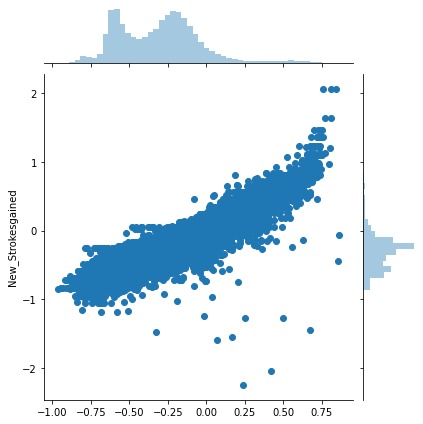

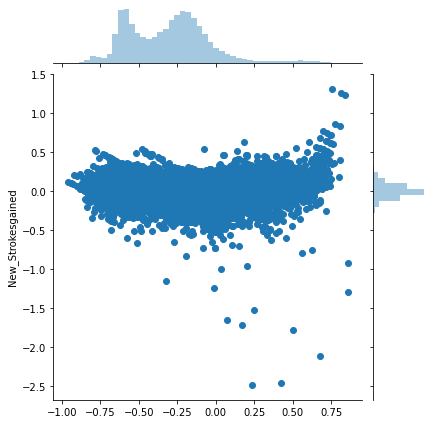

In [ ]:
# 8) evaluate model
# https://scikit-learn.org/stable/modules/model_evaluation.html

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

# plot predicted vs actual and predicted vs residuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.jointplot(y_pred, ytrain) 
sns.jointplot(y_pred, (ytrain - y_pred))

In [ ]:
# Ridge Regression
# https://scikit-learn.org/stable/modules/linear_model.html
# Least squares with L2 regularization:
# minmize ||y - Xw||^2_2 + alpha * ||w||^2_2
# L2 norm here imposes a penalty on the size of the coefficients, the larger the value of alpha, 
# the greater the amount of shrinkage and thus the coefficients become more robust to collinearity

from sklearn.linear_model import Ridge
rr = Ridge(alpha=1.0)
rr.fit(dfnorm, ytrain)
y_pred = rr.predict(dfnorm)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.1050509704506241
0.8612602295932705


In [ ]:
#Decision Tree Regressor==============================================================================

# 4-7) import, instantiate, train, test model
from sklearn.tree import DecisionTreeRegressor                                                                                    
dtr = DecisionTreeRegressor()  
dtr.fit(dfnorm, ytrain)
y_pred = dtr.predict(dfnorm)
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.0007740842369865846
0.9999924668384397


In [ ]:
from sklearn.model_selection import  RandomizedSearchCV

parameters={'min_samples_split' : range(0,100,10),'max_depth': range(1,20,2)}
dtr_random = RandomizedSearchCV(dtr,parameters,n_iter=5)
dtr_random.fit(dfnorm, ytrain)
grid_parm1=dtr_random.best_params_
print(grid_parm1)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

{'min_samples_split': 90, 'max_depth': 7}


In [ ]:
dtr = DecisionTreeRegressor(**grid_parm1)
dtr.fit(dfnorm, ytrain) 


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=90,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
from sklearn.model_selection import cross_val_score
#run cross-validation on best hyperparameters, get auc score
dtr_cv_score = cross_val_score(dtr, dfnorm, ytrain, cv=5)
print("=== All AUC Scores ===")
print(dtr_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree: ",dtr_cv_score.mean())

=== All AUC Scores ===
[0.88166859 0.88857661 0.89238294 0.87262037 0.87725319]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree:  0.8825003414783626


In [ ]:
y_pred = dtr.predict(dfnorm)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.0909366789387183
0.8960369497886578


In [ ]:
#Random Forest Regressor==============================================================================

# 4-7) import, instantiate, train, test model
from sklearn.ensemble import RandomForestRegressor                                                                                    
rfr = RandomForestRegressor()  
rfr.fit(dfnorm, ytrain)
y_pred = rfr.predict(dfnorm)
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.03527242851490221
0.9843587463846479


In [ ]:
parameters={'n_estimators': range(50,100,10),
              'min_samples_split' : range(10,100,10),
              'max_depth': range(1,20,2)}
rfr_random = RandomizedSearchCV(rfr,parameters,n_iter=5)
rfr_random.fit(dfnorm, ytrain)
grid_parm2=rfr_random.best_params_
print(grid_parm2)

{'n_estimators': 70, 'min_samples_split': 50, 'max_depth': 17}


In [ ]:
rfr = RandomForestRegressor(**grid_parm2)
rfr.fit(dfnorm, ytrain) 


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=50, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#run cross-validation on best hyperparameters, get auc score
rfr_cv_score = cross_val_score(rfr, dfnorm, ytrain, cv=5)
print("=== All AUC Scores ===")
print(rfr_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree: ",rfr_cv_score.mean())

=== All AUC Scores ===
[0.89283224 0.89873361 0.90294833 0.88309275 0.8864565 ]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree:  0.8928126870706372


In [ ]:
y_pred = rfr.predict(dfnorm)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.07588009937926737
0.9276136603914529


In [ ]:
##### Gradient Boosting
# 4-7) import, instantiate, train, test model
from sklearn.ensemble import GradientBoostingRegressor
gbc = GradientBoostingRegressor()
gbc.fit(dfnorm, ytrain) 
y_pred = gbc.predict(dfnorm)  
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.08910927104619389
0.9001733227155109


In [ ]:
parameters={'n_estimators': range(50,100,10),
              'min_samples_split' : range(10,100,10),
              'max_depth': range(1,20,2)}
gbc_random = RandomizedSearchCV(gbc,parameters,n_iter=5)
gbc_random.fit(dfnorm, ytrain)
grid_parm3=gbc_random.best_params_
print(grid_parm3)

{'n_estimators': 60, 'min_samples_split': 90, 'max_depth': 7}


In [ ]:
gbc = GradientBoostingRegressor(**grid_parm3)
gbc.fit(dfnorm, ytrain) 
model_score = gbc.score(dfnorm, ytrain)
print('coefficient of determination R^2 of the prediction.:',model_score)



coefficient of determination R^2 of the prediction.: 0.9191508325643439


In [ ]:
#run cross-validation on best hyperparameters, get auc score
gbc_cv_score = cross_val_score(gbc, dfnorm, ytrain, cv=5)
print("=== All AUC Scores ===")
print(gbc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree: ",gbc_cv_score.mean())

=== All AUC Scores ===
[0.89326837 0.89987032 0.90272601 0.88446362 0.88698717]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree:  0.8934630983514872


In [ ]:
y_pred = gbc.predict(dfnorm)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.080193165885608
0.9191508325643439


In [ ]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19877 sha256=e9bba239973057171438cfca262e7ead7e404819b018a4072e8dc8f854bf6085
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
#Test Set Predictions

In [ ]:
Xtest.head()

,clubType,Group,distance,Avg_Handicap,isGir,clubTypeId,gender,imp_age
7725,Pw,Others,64.894763,12.600000,0.875000,11,M,42.0
15284,L,Not Specified,27.735289,9.821618,0.222222,45,M,72.0
42271,9i,Others,115.222219,16.017857,0.800000,10,M,50.0
49180,6i,Others,181.088333,21.164706,1.000000,7,M,39.0
44714,G,Others,78.854401,19.500000,1.000000,44,M,44.0


In [ ]:
# Preprocessing Test Dataset
# Robust Scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
# removes the median and scales the data according to the inter-quartile range (defaults to Q3-Q1)
# xi_scale = (xi - Q2(x))/(Q3(x) - Q1(x)) where Q1, Q2, and Q3 are 25th, 50th and 75th quantiles
# robust to outliers, but the outliers themselves are still present in the transformed data.

dfnumrsT = pd.DataFrame(rs.transform(Xtest[numericvars]), columns=['rs_'+x for x in numericvars], index = Xtest.index)
dfnumrsT = pd.concat([Xtest, dfnumrsT], axis=1)
dfnumrsT = dfnumrsT.drop(numericvars, axis=1)
dfnumrsT.head()

,clubType,Group,clubTypeId,gender,rs_Avg_Handicap,rs_distance,rs_isGir,rs_imp_age
7725,Pw,Others,11,M,-0.119431,-0.417349,0.200893,-0.305309
15284,L,Not Specified,45,M,-0.356450,-0.789932,-0.615079,1.569691
42271,9i,Others,10,M,0.172139,0.087265,0.107143,0.194691
49180,6i,Others,7,M,0.611207,0.747679,0.357143,-0.492809
44714,G,Others,44,M,0.469194,-0.277381,0.357143,-0.180309


In [ ]:
from sklearn.preprocessing import OneHotEncoder
dfcatT = pd.DataFrame(ohe.transform(dfnumrsT[categoricalvars]), columns=ohe.get_feature_names(),index = dfnumrsT.index)
dfcatT = pd.concat([dfnumrsT, dfcatT], axis=1)
dfcatT = dfcatT.drop(categoricalvars, axis=1)
dfcatT.reset_index(inplace = True)
dfcatT.drop(columns = ["index"], inplace = True)
dfcatT.head()

,rs_Avg_Handicap,rs_distance,rs_isGir,rs_imp_age,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19,x0_20,x0_22,x0_24,x0_25,x0_26,x0_27,x0_28,x0_29,x0_30,x0_31,x0_32,x0_33,x0_34,x0_35,x0_36,x0_37,x0_38,x0_39,...,x1_51�,x1_52�,x1_53�,x1_54�,x1_55�,x1_56�,x1_57�,x1_58�,x1_5h,x1_5i,x1_5w,x1_60�,x1_62�,x1_64�,x1_6h,x1_6i,x1_6w,x1_7h,x1_7i,x1_7w,x1_8h,x1_8i,x1_8w,x1_9h,x1_9i,x1_9w,x1_A,x1_Dr,x1_G,x1_L,x1_Pu,x1_Pw,x1_S,x1_UL,x1_X,x1_XX,x2_Not Specified,x2_Others,x2_Performance,x3_M
0,-0.119431,-0.417349,0.200893,-0.305309,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
1,-0.356450,-0.789932,-0.615079,1.569691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,0.172139,0.087265,0.107143,0.194691,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,0.611207,0.747679,0.357143,-0.492809,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0.469194,-0.277381,0.357143,-0.180309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# (Sample Vector) Normalization: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
# Normalization is the process of scaling individual *samples* (not features - i.e., operation is along rows!) to have unit norm. 
# This process can be useful if you plan to use a quadratic form such as the dot-product 
# or any other kernel to quantify the similarity of any pair of samples.
# l1: sum of abs values is 1
# l2: sum of square of values is 1

from sklearn.preprocessing import Normalizer
dfnormT = pd.DataFrame(norm.transform(dfcatT), columns=['norm_'+x for x in dfcatT.columns])
dfnormT.head()

# dfnorm.apply(lambda x: abs(x)).sum(axis=1) # for l1 norm these will all be ones
# dfnorm.apply(lambda x: x*x).sum(axis=1) # for l2 norm these will all be ones

,norm_rs_Avg_Handicap,norm_rs_distance,norm_rs_isGir,norm_rs_imp_age,norm_x0_2,norm_x0_3,norm_x0_4,norm_x0_5,norm_x0_6,norm_x0_7,norm_x0_8,norm_x0_9,norm_x0_10,norm_x0_11,norm_x0_12,norm_x0_13,norm_x0_14,norm_x0_15,norm_x0_16,norm_x0_17,norm_x0_18,norm_x0_19,norm_x0_20,norm_x0_22,norm_x0_24,norm_x0_25,norm_x0_26,norm_x0_27,norm_x0_28,norm_x0_29,norm_x0_30,norm_x0_31,norm_x0_32,norm_x0_33,norm_x0_34,norm_x0_35,norm_x0_36,norm_x0_37,norm_x0_38,norm_x0_39,...,norm_x1_51�,norm_x1_52�,norm_x1_53�,norm_x1_54�,norm_x1_55�,norm_x1_56�,norm_x1_57�,norm_x1_58�,norm_x1_5h,norm_x1_5i,norm_x1_5w,norm_x1_60�,norm_x1_62�,norm_x1_64�,norm_x1_6h,norm_x1_6i,norm_x1_6w,norm_x1_7h,norm_x1_7i,norm_x1_7w,norm_x1_8h,norm_x1_8i,norm_x1_8w,norm_x1_9h,norm_x1_9i,norm_x1_9w,norm_x1_A,norm_x1_Dr,norm_x1_G,norm_x1_L,norm_x1_Pu,norm_x1_Pw,norm_x1_S,norm_x1_UL,norm_x1_X,norm_x1_XX,norm_x2_Not Specified,norm_x2_Others,norm_x2_Performance,norm_x3_M
0,-0.057448,-0.200750,0.096632,-0.146857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.481013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.481013,0.0,0.0,0.0,0.0,0.000000,0.481013,0.0,0.481013
1,-0.129355,-0.286665,-0.223211,0.569638,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.362898,0.0,0.000000,0.0,0.0,0.0,0.0,0.362898,0.000000,0.0,0.362898
2,0.085153,0.043168,0.053001,0.096308,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.494672,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.494672,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.494672,0.0,0.494672
3,0.265416,0.324679,0.155089,-0.214002,0.0,0.0,0.0,0.0,0.0,0.434249,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.434249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.434249,0.0,0.434249
4,0.222241,-0.131386,0.169166,-0.085406,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.473665,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.473665,0.0,0.473665


In [ ]:
from vecstack import stacking
#STACKING MODELS=====================================================================
print("Ensemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Regressor\n")

models = [ GradientBoostingRegressor(**grid_parm3), 
          RandomForestRegressor(**grid_parm2), 
          DecisionTreeRegressor(**grid_parm1)]
      
S_Train, S_Test = stacking(models,                   
                           dfnorm, ytrain, dfnormT,   
                           regression=True, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None,
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

Ensemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Regressor

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


    fold  0:  [0.06313864]
    fold  1:  [0.06184709]
    fold  2:  [0.06058261]
    fold  3:  [0.06149461]
    fold  4:  [0.06210001]
    ----
    MEAN:     [0.06183259] + [0.00083117]
    FULL:     [0.06183262]

model  1:     [RandomForestRegressor]
    fold  0:  [0.06358198]
    fold  1:  [0.06200588]
    fold  2:  [0.06100114]
    fold  3:  [0.06174213]
    fold  4:  [0.06227564]
    ----
    MEAN:     [0.06212135] + [0.00084490]
    FULL:     [0.06212138]

model  2:     [DecisionTreeRegressor]
    fold  0:  [0.06728707]
    fold  1:  [0.06503778]
    fold  2:  [0.06482736]
    fold  3:  [0.06519609]
    fold  4:  [0.06576155]
    ----
    MEAN:     [0.06562197] + [0.00088838]
    FULL:     [0.06562199]



In [ ]:
#STACKING - CONTRUCT A GRADIENT BOOSTING MODEL==============================
model = GradientBoostingRegressor()
    
model = model.fit(S_Train, ytrain)
y_pred = model.predict(S_Train)

print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.08843241905883101
0.9016840806792779


In [ ]:
#Randomized Search for hyperparameter tuning

parameters={'n_estimators': range(50,100,10),
              'min_samples_split' : range(10,100,10),
              'max_depth': range(1,20,2)}
gbc_random = RandomizedSearchCV(model,parameters,n_iter=5)
gbc_random.fit(S_Train, ytrain)
grid_parm4=gbc_random.best_params_
print(grid_parm4)

{'n_estimators': 50, 'min_samples_split': 50, 'max_depth': 7}


In [ ]:
gbc = GradientBoostingRegressor(**grid_parm4)
gbc.fit(S_Train, ytrain) 


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=50,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#run cross-validation on best hyperparameters, get auc score
gbc_cv_score = cross_val_score(gbc, S_Train, ytrain, cv=5)
print("=== All AUC Scores ===")
print(gbc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree: ",gbc_cv_score.mean())

=== All AUC Scores ===
[0.89108504 0.89243037 0.90008229 0.87731967 0.88052313]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree:  0.888288098385685


In [ ]:
y_pred = gbc.predict(S_Train)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytrain, y_pred))) # rmse
print(metrics.r2_score(ytrain, y_pred)) # r-square

0.08397734092922411
0.9113405420173672


In [ ]:
y_pred = gbc.predict(S_Test)  

from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytest, y_pred))) # rmse
print(metrics.r2_score(ytest, y_pred)) # r-square

0.11270826315072695
0.8430414193835881


In [ ]:
#Decision Tree Regressor==============================================================================

# 4-7) import, instantiate, train, test model
from sklearn.tree import DecisionTreeRegressor                                                                                    
dtr11 = DecisionTreeRegressor()  
dtr11.fit(dfnorm, ytrain)
y_pred11 = dtr11.predict(dfnormT)
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(ytest, y_pred11))) # rmse
print(metrics.r2_score(ytest, y_pred11)) # r-square



0.14331378534867978
0.7462246225037095


In [ ]:
#Random Forest Regressor==============================================================================

# 4-7) import, instantiate, train, test model
from sklearn.ensemble import RandomForestRegressor                                                                                    
rfr11 = RandomForestRegressor()  
rfr11.fit(dfnorm, ytrain)
y_pred111 = rfr11.predict(dfnormT)
print(np.sqrt(metrics.mean_squared_error(ytest, y_pred111))) # rmse
print(metrics.r2_score(ytest, y_pred111)) # r-square

0.11554617925873084
0.835037691035891


In [ ]:
##### Gradient Tree Boosting
# 4-7) import, instantiate, train, test model
from sklearn.ensemble import GradientBoostingRegressor
gbc11 = GradientBoostingRegressor()
gbc11.fit(dfnorm, ytrain) 
y_pred1111 = gbc11.predict(dfnormT)  
print(np.sqrt(metrics.mean_squared_error(ytest, y_pred1111))) # rmse
print(metrics.r2_score(ytest, y_pred1111)) # r-square

0.1126575997202093
0.8431824964023945
